In [187]:
# Code by Sanket More

import pandas as pd
import datetime as dt
import numpy as np
from pandas import get_dummies
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error 
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import pickle
from xgboost import XGBRegressor

In [173]:
df = pd.read_csv('train.csv')

In [174]:
#df.head()

In [175]:
#df.shape

In [176]:
#df.info()

In [177]:
df['Date'] = df['Year'].astype(str) +'-'+ df['Month'].astype(str)+'-'+ df['Day'].astype(str) +' '+ df['Hour'].astype(str) +':'+ df['Minute'].astype(str)+':00' 
df['Date'] = pd.to_datetime(df['Date'])

In [15]:
#df['Weekday'] = df['Date'].dt.weekday
#does not improve accuracy after inclusion

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175296 entries, 0 to 175295
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Year                175296 non-null  int64         
 1   Month               175296 non-null  int64         
 2   Day                 175296 non-null  int64         
 3   Hour                175296 non-null  int64         
 4   Minute              175296 non-null  int64         
 5   Clearsky DHI        175296 non-null  int64         
 6   Clearsky DNI        175296 non-null  int64         
 7   Clearsky GHI        175296 non-null  int64         
 8   Cloud Type          175296 non-null  int64         
 9   Dew Point           175296 non-null  float64       
 10  Temperature         175296 non-null  float64       
 11  Pressure            175296 non-null  int64         
 12  Relative Humidity   175296 non-null  float64       
 13  Solar Zenith Angle  175296 no

In [8]:
#df['Cloud Type'].value_counts()

In [178]:
#one hot encoding Cloud types

# no need to include N/A further as dummy variable
Cloud_Type_dict = {
    0:    'Clear',
    1:    'Probably Clear',
    2:    'Fog',
    3:    'Water',
    4:    'Super-Cooled Water',
    5:    'Mixed',
    6:    'Opaque Ice',
    7:    'Cirrus',
    8:    'Overlapping',
    9:    'Overshooting',
#    10:    'Unknown', 
    11:    'Dust',
    12:    'Smoke',
#    15:    'N/A'   
}
df['Cloud Type mod'] = df['Cloud Type'].map(Cloud_Type_dict)
#df['Cloud Type mod']=df['Cloud Type mod'].fillna(value = 'N/A')


Cloud_Type_dummies = pd.get_dummies(df['Cloud Type mod'], prefix='Cloud_Type', prefix_sep='_')
df = pd.concat([df,Cloud_Type_dummies], axis=1)
df = df.drop(['Cloud Type','Cloud Type mod'], axis =1)

In [10]:
#check
#df['Cloud_Type_Clear'].value_counts()

In [11]:
# we mostly have only 0,1,3,4 as values
#df['Fill Flag'].value_counts()

In [179]:
# no need to include N/A further as dummy variable
Fill_Flag_dict = {
#    0: 'N/A',
#    1: 'Missing Image',
    2: 'Low Irradiance',
    3: 'Exceeds Clearsky',
#    4: 'Missing CLoud Properties',
    5: 'Rayleigh Violation'
    
}
df['Fill Flag mod'] = df['Fill Flag'].map(Fill_Flag_dict)
#df['Fill Flag mod']=df['Fill Flag mod'].fillna(value = 'N/A')

In [13]:
#df['Fill Flag mod'].value_counts()

In [180]:
Fill_Flag_dummies = pd.get_dummies(df['Fill Flag mod'], prefix='Fill_Flag', prefix_sep='_')
df = pd.concat([df,Fill_Flag_dummies], axis=1)
df = df.drop(['Fill Flag','Fill Flag mod'], axis =1)

In [15]:
#df.columns

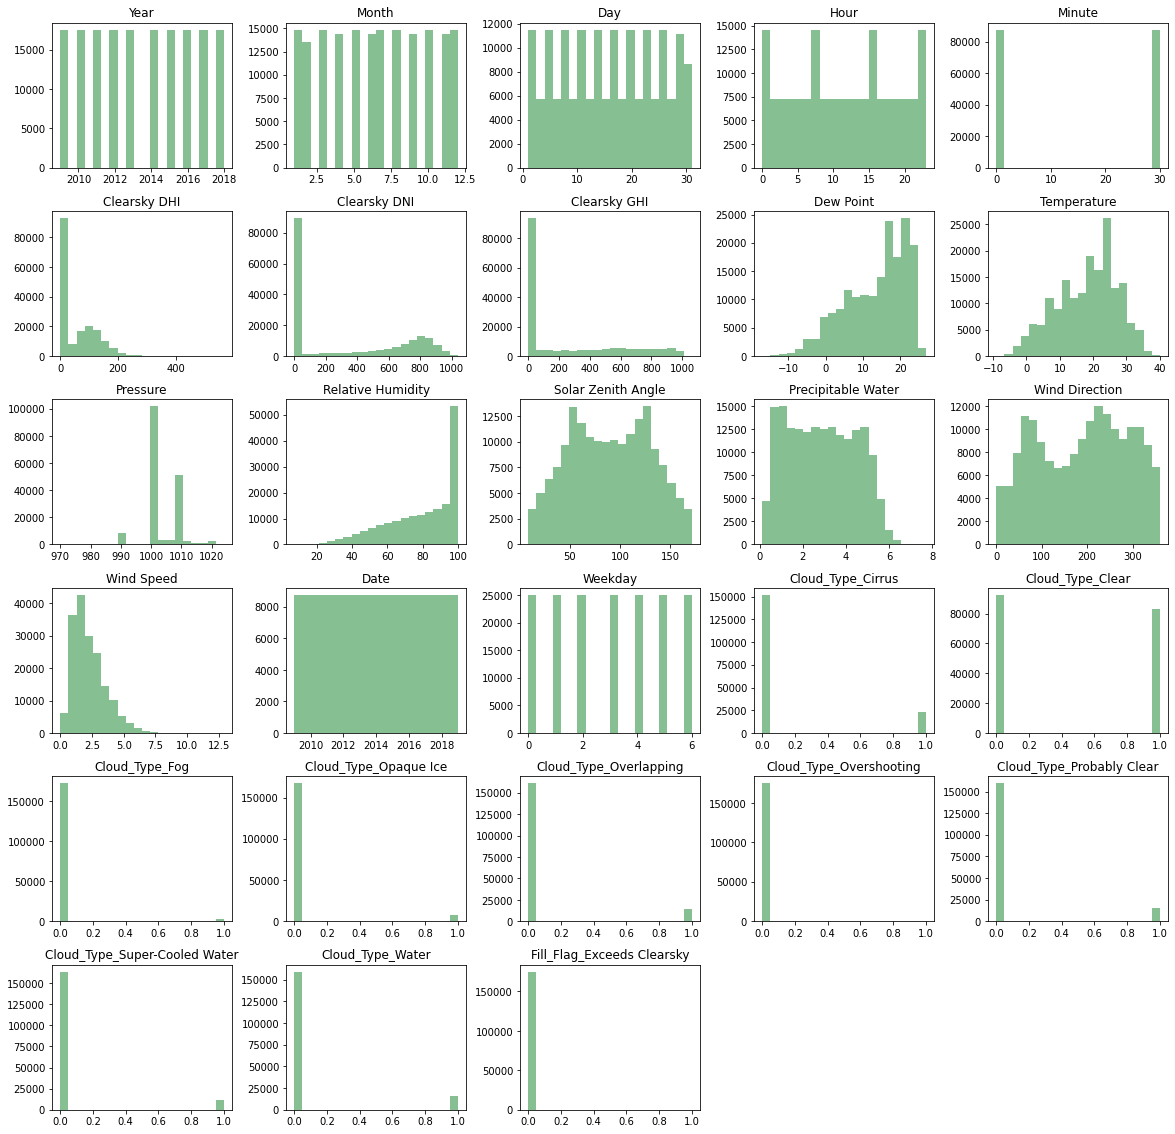

In [20]:
a =df.hist(bins=20, figsize=(20, 20) ,color='#86bf91',grid=False)

In [181]:
# keeping original df in df1
df1 = df.copy()

df = df.set_index(df['Date'], drop = True)

#trying to not drop Day, Month, Hour, Year since these are useful for prediction
#df = df.drop(['Year','Month','Day','Hour','Minute','Date'], axis =1)
df = df.drop(['Minute','Date'], axis =1)

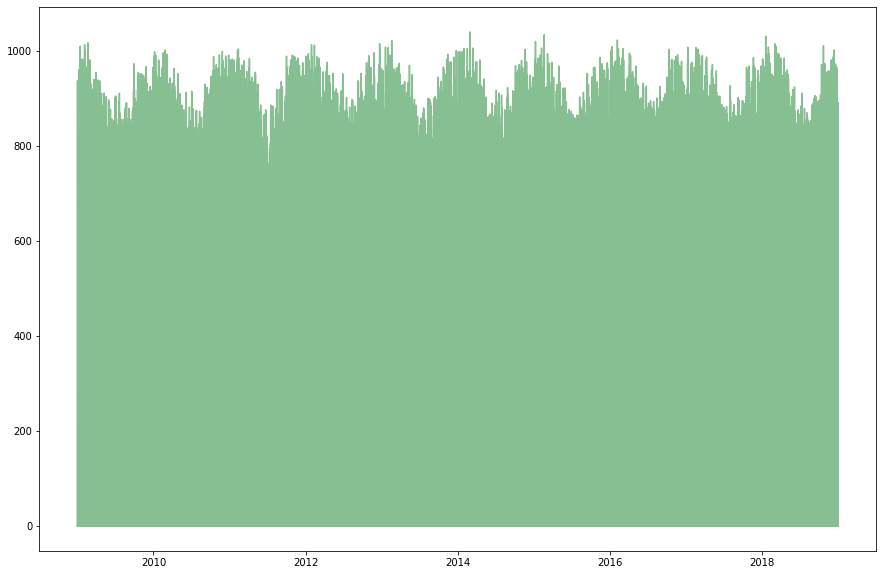

In [11]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
plt.plot(df['Clearsky DNI'],color='#86bf91')

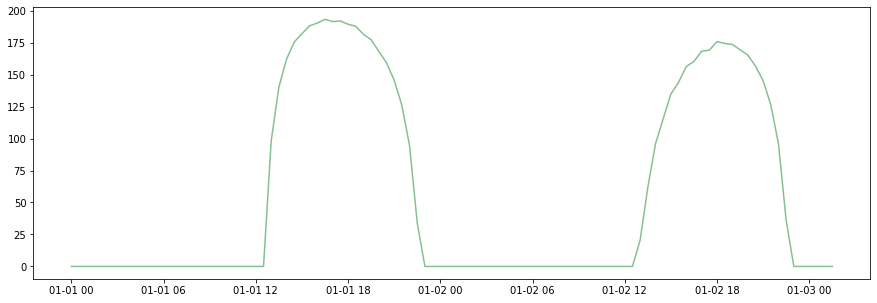

In [150]:

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)
plt.plot(df['Clearsky DNI'].iloc[0:100]** (1. / 1.3),color='#86bf91')


In [36]:
64**(1./3)

3.9999999999999996

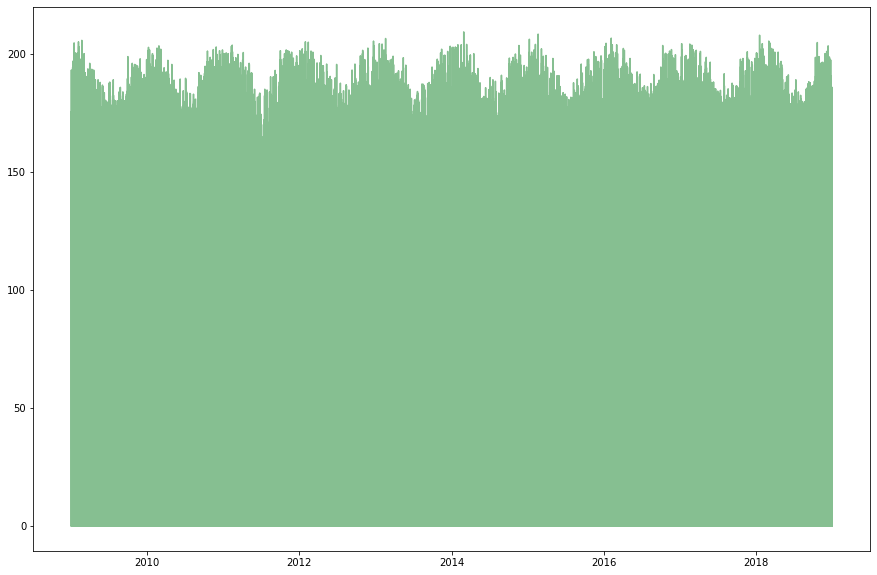

In [151]:
# taking cube root of DNI column since it had least accuracy and then checking accuracy
df['Clearsky DNI'] = df['Clearsky DNI']** (1. / 1.3)
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
plt.plot(df['Clearsky DNI'],color='#86bf91')
#x ** (1. / 3)

In [20]:
#df.columns

# There seems to be a seasonal component

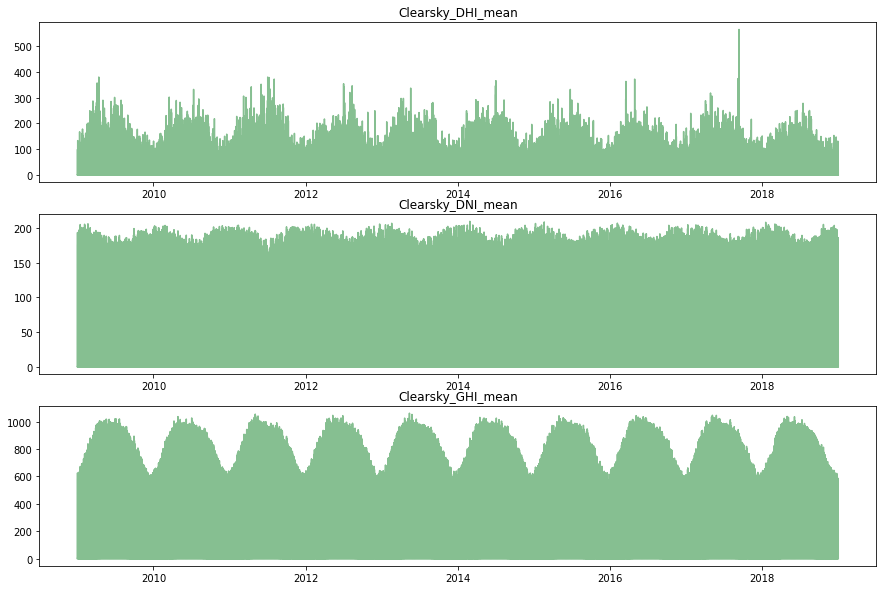

In [152]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
ax1 = plt.subplot(311)
plt.plot(df['Clearsky DHI'],color='#86bf91')
ax1.title.set_text('Clearsky_DHI_mean')

ax2 = plt.subplot(312, sharex = ax1)
plt.plot(df['Clearsky DNI'],color='#86bf91')
ax2.title.set_text('Clearsky_DNI_mean')

ax3 = plt.subplot(313, sharex = ax1)
plt.plot(df['Clearsky GHI'],color='#86bf91')
ax3.title.set_text('Clearsky_GHI_mean')

#plt.figure(figsize=(3000,100))
plt.show()

In [153]:
Clearsky_DHI_mean = pd.DataFrame(df['Clearsky DHI'].groupby(df.index.month).mean())
Clearsky_DNI_mean = pd.DataFrame(df['Clearsky DNI'].groupby(df.index.month).mean())
Clearsky_GHI_mean = pd.DataFrame(df['Clearsky GHI'].groupby(df.index.month).mean())

# Checking monthly trend. There are peaks at the mid of the year

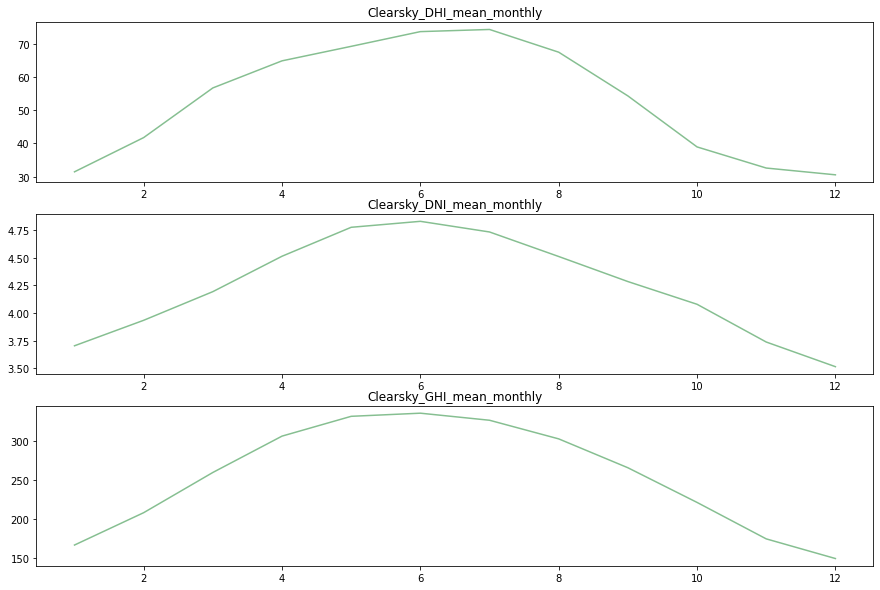

In [41]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)


ax1 = plt.subplot(311)
plt.plot(Clearsky_DHI_mean,color='#86bf91')
ax1.title.set_text('Clearsky_DHI_mean_monthly')

ax2 = plt.subplot(312, sharex = ax1)
plt.plot(Clearsky_DNI_mean,color='#86bf91')
ax2.title.set_text('Clearsky_DNI_mean_monthly')

ax3 = plt.subplot(313, sharex = ax1)
plt.plot(Clearsky_GHI_mean,color='#86bf91')
ax3.title.set_text('Clearsky_GHI_mean_monthly')

plt.show()

In [154]:
Clearsky_DHI_mean_day = pd.DataFrame(df['Clearsky DHI'].groupby(df.index.day).mean())
Clearsky_DNI_mean_day = pd.DataFrame(df['Clearsky DNI'].groupby(df.index.day).mean())
Clearsky_GHI_mean_day = pd.DataFrame(df['Clearsky GHI'].groupby(df.index.day).mean())

# Checking Daily trend. DHI seems to follow an inverse curve than other two

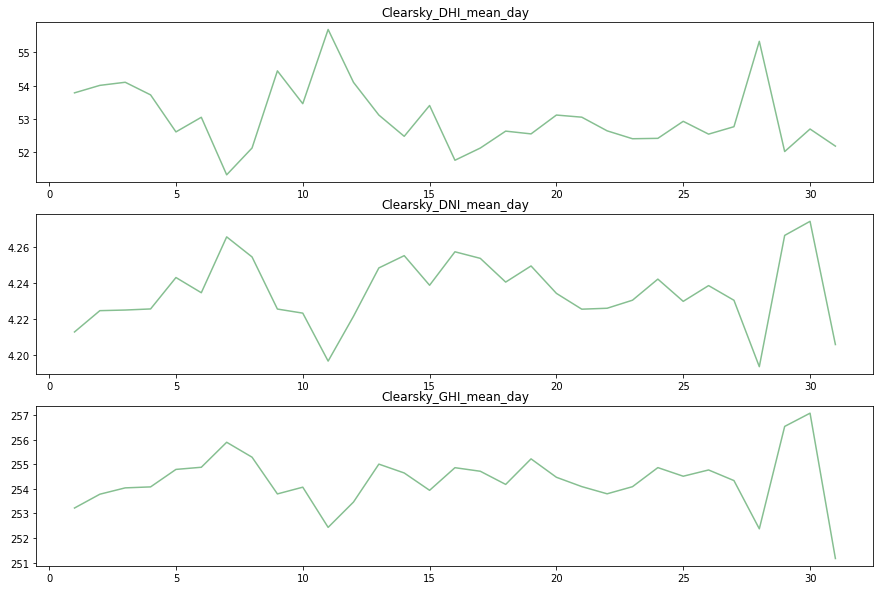

In [43]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)


ax1 = plt.subplot(311)
plt.plot(Clearsky_DHI_mean_day,color='#86bf91')
ax1.title.set_text('Clearsky_DHI_mean_day')

ax2 = plt.subplot(312, sharex = ax1)
plt.plot(Clearsky_DNI_mean_day,color='#86bf91')
ax2.title.set_text('Clearsky_DNI_mean_day')

ax3 = plt.subplot(313, sharex = ax1)
plt.plot(Clearsky_GHI_mean_day,color='#86bf91')
ax3.title.set_text('Clearsky_GHI_mean_day')

plt.show()

In [155]:
Clearsky_DHI_mean_hour = pd.DataFrame(df['Clearsky DHI'].groupby(df.index.hour).mean())
Clearsky_DNI_mean_hour = pd.DataFrame(df['Clearsky DNI'].groupby(df.index.hour).mean())
Clearsky_GHI_mean_hour = pd.DataFrame(df['Clearsky GHI'].groupby(df.index.hour).mean())

# Checking hourly trend. There is an obvious trend seen here which peaks at around 1700

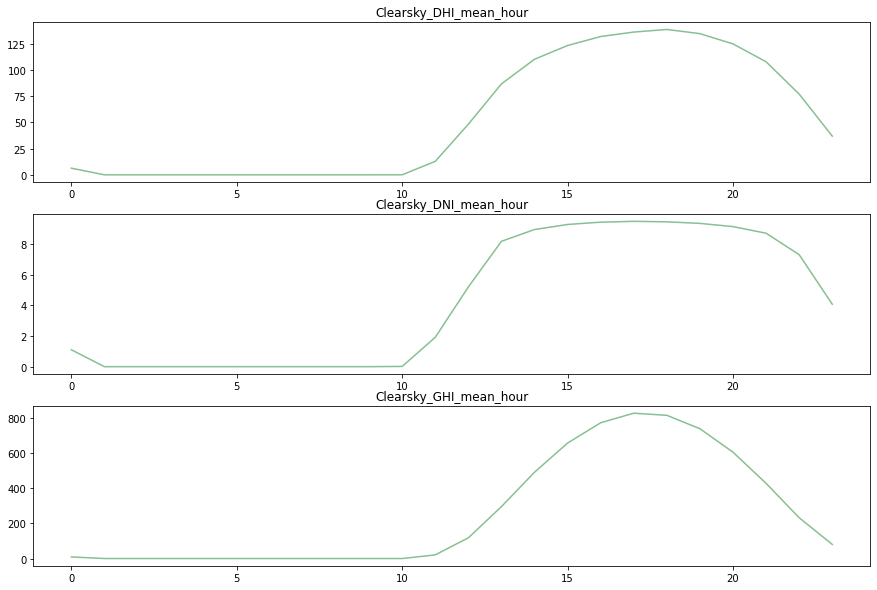

In [45]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)


ax1 = plt.subplot(311)
plt.plot(Clearsky_DHI_mean_hour,color='#86bf91')
ax1.title.set_text('Clearsky_DHI_mean_hour')

ax2 = plt.subplot(312, sharex = ax1)
plt.plot(Clearsky_DNI_mean_hour,color='#86bf91')
ax2.title.set_text('Clearsky_DNI_mean_hour')

ax3 = plt.subplot(313, sharex = ax1)
plt.plot(Clearsky_GHI_mean_hour,color='#86bf91')
ax3.title.set_text('Clearsky_GHI_mean_hour')

plt.show()

In [156]:
Clearsky_DHI_mean_weekday = pd.DataFrame(df['Clearsky DHI'].groupby(df.index.weekday).mean())
Clearsky_DNI_mean_weekday = pd.DataFrame(df['Clearsky DNI'].groupby(df.index.weekday).mean())
Clearsky_GHI_mean_weekday = pd.DataFrame(df['Clearsky GHI'].groupby(df.index.weekday).mean())

# Weekday also seems a relevant parameter to the indices

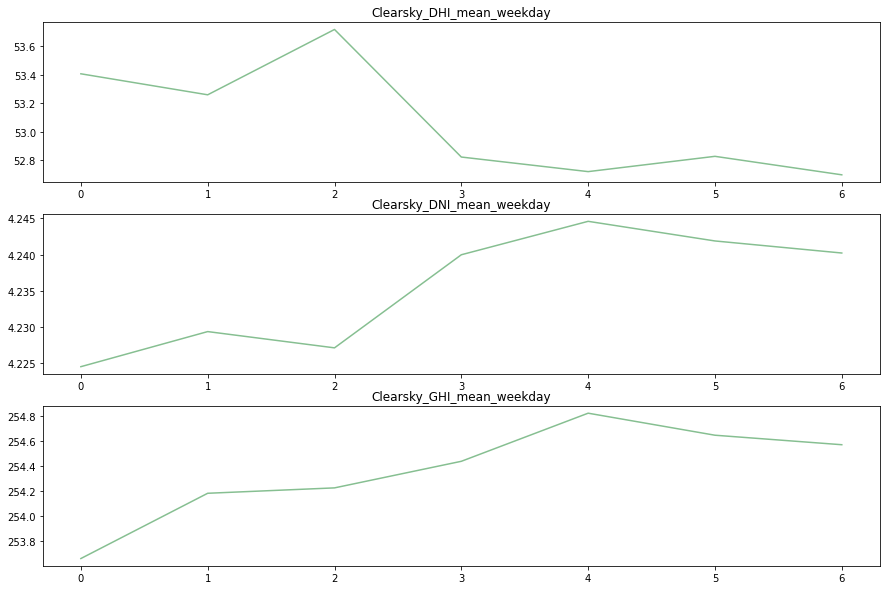

In [47]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)


ax1 = plt.subplot(311)
plt.plot(Clearsky_DHI_mean_weekday,color='#86bf91')
ax1.title.set_text('Clearsky_DHI_mean_weekday')

ax2 = plt.subplot(312, sharex = ax1)
plt.plot(Clearsky_DNI_mean_weekday,color='#86bf91')
ax2.title.set_text('Clearsky_DNI_mean_weekday')

ax3 = plt.subplot(313, sharex = ax1)
plt.plot(Clearsky_GHI_mean_weekday,color='#86bf91')
ax3.title.set_text('Clearsky_GHI_mean_weekday')

plt.show()

In [28]:
#df.shape

In [157]:
X = df.drop(['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'], axis =1)
y = df['Clearsky DHI']

In [30]:
#X.shape

In [31]:
#y.shape

In [50]:
print(df.index.date.min())
print(df.index.date.max())

2009-01-01
2018-12-31


In [158]:
train_date = ['2009-01-01', '2016-12-31'] # training date range
valid_date = ['2017-01-01', '2018-12-31'] # validation date range
#test_date = ['2017-08-16', '2017-08-31'] # test date range
X_train = X[train_date[0]:train_date[1]]
y_train = y[train_date[0]:train_date[1]]
X_valid = X[valid_date[0]:valid_date[1]]
y_valid = y[valid_date[0]:valid_date[1]]
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(140256, 22)
(140256,)
(35040, 22)
(35040,)


In [159]:
# scaling the X datasets
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
X_valid_sc =  scaler.transform(X_valid)
X_valid_sc = pd.DataFrame(X_valid_sc, columns=X_valid.columns)
print(X_train_sc.shape)
print(X_valid_sc.shape)

(140256, 22)
(35040, 22)


# Performance LR
MSE 816.02 </br>
R2 0.7802

In [35]:
lr = LinearRegression()
parameters = {
#    'class_weight':['balanced'],
#    'C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1],
#    'kernel':['poly', 'rbf', 'sigmoid'],
#    'degree' : [1,2,3,4]
    
}
model = GridSearchCV(estimator =lr,param_grid = parameters, cv = 3, scoring = 'neg_mean_squared_error' )
model_cv=model.fit(X_train_sc,y_train)
y_predict = model_cv.predict(X_valid_sc)

print(mean_squared_error(y_valid,y_predict))
print(r2_score(y_valid,y_predict))


782.5364708533401
0.789263376454353


# linear regression is not predicting it correctly

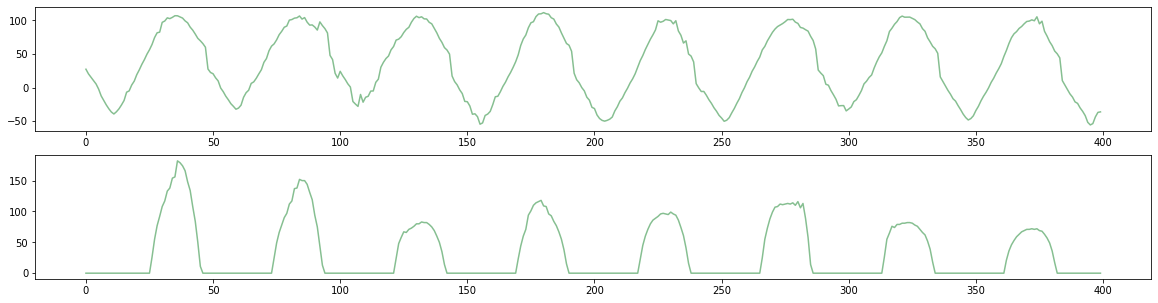

In [36]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
#plt.plot(X_valid_sc.index[0:200],y_predict[0:200], '+')

ax1 = plt.subplot(211)
plt.plot(X_valid_sc.index[0:400],y_predict[0:400],color='#86bf91')
#ax2.title.set_text('Clearsky_DNI_mean_hour')

ax2 = plt.subplot(212, sharex = ax1)
plt.plot(X_valid_sc.index[0:400],y_valid[0:400],color='#86bf91')
#ax2.title.set_text('Clearsky_DNI_mean_hour')

# Performance Ridge
MSE 811.68 </br>
R2 0.7814

In [37]:
Ridge_regressor = Ridge()
parameters = {
#    'alpha': [1,10,100,1000,5000,10000],
    'alpha': [5000],    
#    'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    'solver': ['sparse_cg']
#    'kernel':['poly', 'rbf', 'sigmoid'],
#    'degree' : [1,2,3,4]
    
}
model = GridSearchCV(estimator =Ridge_regressor,param_grid = parameters, cv = 3, scoring = 'neg_mean_squared_error' )
model_cv=model.fit(X_train_sc,y_train)
y_predict = model_cv.predict(X_valid_sc)

print(mean_squared_error(y_valid,y_predict))
print(r2_score(y_valid,y_predict))

# best params - {'alpha': 5000, 'solver': 'sparse_cg'}

781.5412684477501
0.7895313838923574


In [38]:
model_cv.best_params_

{'alpha': 5000, 'solver': 'sparse_cg'}

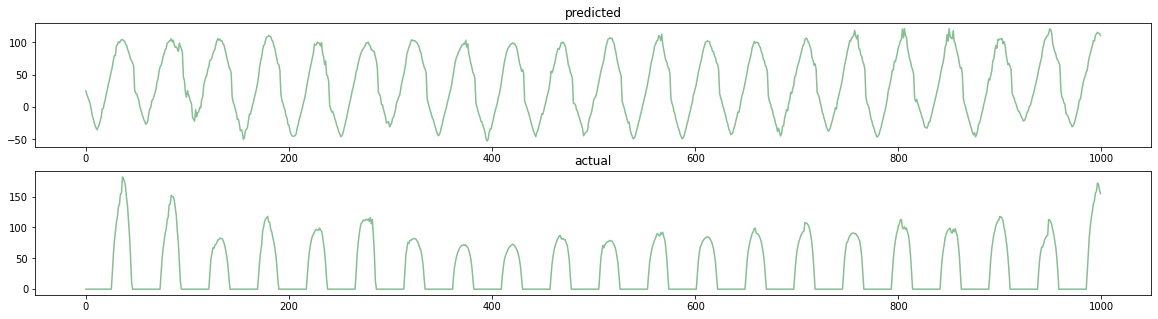

In [39]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
#plt.plot(X_valid_sc.index[0:200],y_predict[0:200], '+')

ax1 = plt.subplot(211)
plt.plot(X_valid_sc.index[0:1000],y_predict[0:1000],color='#86bf91')
ax1.title.set_text('predicted')

ax2 = plt.subplot(212, sharex = ax1)
plt.plot(X_valid_sc.index[0:1000],y_valid[0:1000],color='#86bf91')
ax2.title.set_text('actual')

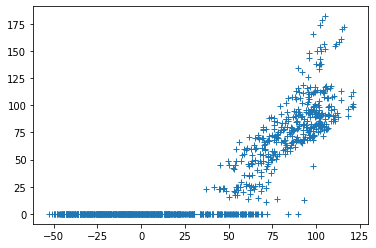

In [191]:
plt.plot(y_predict[0:1000],y_valid[0:1000],'+')

# Performance Random Forest- for DHI
MSE 299.02 </br>
R2 0.9194

after using day month year hour in the model </br>
MSE 262.04 </br>
R2 0.9294


In [64]:
forest_mod = RandomForestRegressor()
parameters = {
#    'n_estimators': [20,50,70],
    'n_estimators': [70],    
#    'min_samples_leaf': [20,30,40,50]
    'min_samples_leaf': [20]    
#    'kernel':['poly', 'rbf', 'sigmoid'],
#    'degree' : [1,2,3,4]
    
}
model = GridSearchCV(estimator =forest_mod,param_grid = parameters, cv = 3, scoring = 'neg_mean_squared_error' )
model_cv_DHI=model.fit(X_train_sc,y_train)
y_predict = model_cv_DHI.predict(X_valid_sc)

print(mean_squared_error(y_valid,y_predict))
print(r2_score(y_valid,y_predict))
print(model_cv_DHI.best_params_)

# best params - {'min_samples_leaf': 20, 'n_estimators': 50}

263.001543595993
0.9291738348958049
{'min_samples_leaf': 20, 'n_estimators': 70}


# Adaboost 
MSE: 3253.56
R2: 0.9765

In [49]:
mdl_adaboost = AdaBoostRegressor()
parameters = {
    'n_estimators': [50,100,200],
#    'n_estimators': [50],    
#    'min_samples_leaf': [20,30,40,50]
#    'min_samples_leaf': [20] 
    'learning_rate' : [0.1]
#    'kernel':['poly', 'rbf', 'sigmoid'],
#    'degree' : [1,2,3,4]
    
}
model = GridSearchCV(estimator =mdl_adaboost,param_grid = parameters, cv = 3, scoring = 'neg_mean_squared_error' )
model_cv_DHI_ada=model.fit(X_train_sc,y_train)
y_predict = model_cv_DHI_ada.predict(X_valid_sc)

print(mean_squared_error(y_valid,y_predict))
print(r2_score(y_valid,y_predict))
print(model_cv_DHI_ada.best_params_)

# best params - {'learning_rate': 0.1, 'n_estimators': 100}

3253.5656126684717
0.9765772776076901
{'learning_rate': 0.1, 'n_estimators': 100}


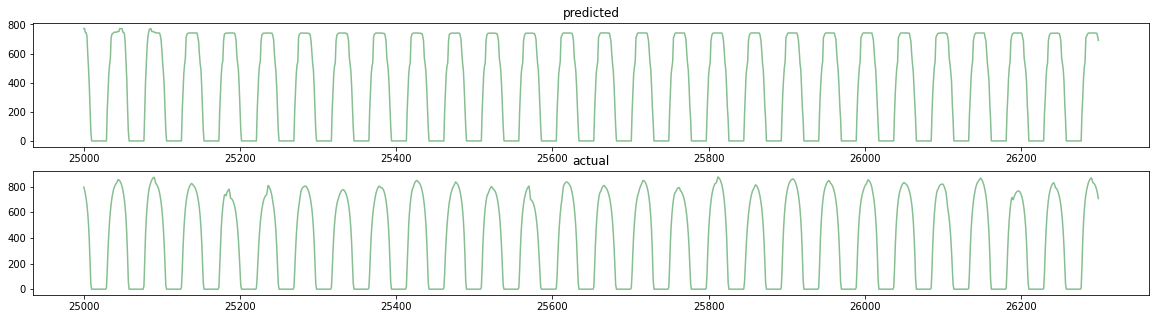

In [55]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
#plt.plot(X_valid_sc.index[0:200],y_predict[0:200], '+')

ax1 = plt.subplot(211)
plt.plot(X_valid_sc.index[25000:26300],y_predict[25000:26300],color='#86bf91')
ax1.title.set_text('predicted')

ax2 = plt.subplot(212, sharex = ax1)
plt.plot(X_valid_sc.index[25000:26300],y_valid[25000:26300],color='#86bf91')
ax2.title.set_text('actual')

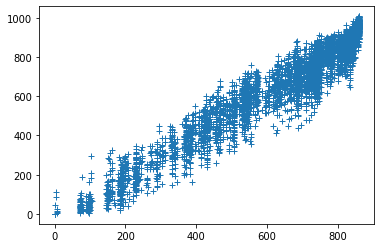

In [56]:
plt.plot(y_predict[0:10000],y_valid[0:10000],'+')

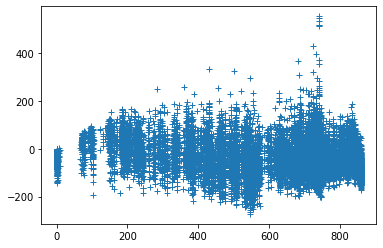

In [57]:
#residual plot
a = y_predict - y_valid
plt.plot(y_predict[0:35000],a[0:35000],'+')

#model predicts better at lower values

# For DNI

In [182]:
# X will be the same, we need to change Y 
y = df['Clearsky DNI']
y_train = y[train_date[0]:train_date[1]]
y_valid = y[valid_date[0]:valid_date[1]]

print(y_train.shape)
print(y_valid.shape)

# we will be using the earlier scaled Xs

(140256,)
(35040,)


# Random forest performance for DNI
MSE 2125.04 </br>
R2 0.9847

after using day month year hour in the model </br>
MSE 1544 </br>
R2 0.9888

with XGboost </br>
MSE 1519.152825865069 </br>
R2 0.9890634770747571

after using sq root transformation </br>
MSE 0.1564 </br>
R2 0.9918

In [161]:
# using the same template for DNI
forest_mod = RandomForestRegressor()
parameters = {
#    'n_estimators': [55,60,65,70],
    'n_estimators': [60],    
#    'min_samples_leaf': [10,20]
    'min_samples_leaf': [20]    
#    'kernel':['poly', 'rbf', 'sigmoid'],
#    'degree' : [1,2,3,4]
    
}
model = GridSearchCV(estimator =forest_mod,param_grid = parameters, cv = 3, scoring = 'neg_mean_squared_error' )
model_cv_DNI=model.fit(X_train_sc,y_train)
y_predict = model_cv_DNI.predict(X_valid_sc)

print(mean_squared_error(y_valid,y_predict))
print(r2_score(y_valid,y_predict))
print(model_cv_DNI.best_params_)

# best params - {'min_samples_leaf': 20, 'n_estimators': 60}

53.02689594351497
0.9916190382846412
{'min_samples_leaf': 20, 'n_estimators': 60}


In [59]:
print(mean_squared_error(y_valid,y_predict))

0.15645323289971177


In [190]:
XGBRegressor_model = XGBRegressor()
parameters = {
    'n_estimators': [10,20,50],
#    'n_estimators': [60],    
#    'min_samples_leaf': [10,20]
#    'min_samples_leaf': [20]    
#    'kernel':['poly', 'rbf', 'sigmoid'],
#    'degree' : [1,2,3,4]
    
}
model = GridSearchCV(estimator =XGBRegressor_model,param_grid = parameters, cv = 3, scoring = 'neg_mean_squared_error' )
model_cv_DNI=model.fit(X_train_sc,y_train)
y_predict = model_cv_DNI.predict(X_valid_sc)

print(mean_squared_error(y_valid,y_predict))
print(r2_score(y_valid,y_predict))
print(model_cv_DNI.best_params_)

# {'n_estimators': 55}

1519.152825865069
0.9890634770747571
{'n_estimators': 20}


In [259]:
a = []
for i in range(0,len(y_predict)):
    
    if (y_predict[i]<10):
        a.append(0)
    else:
        a.append(y_predict[i])
y_predict = np.array(a)
print(mean_squared_error(y_valid,y_predict))
print(r2_score(y_valid,y_predict))

1519.0054513936564
0.9890645380373263


# Adaboost for DNI
MSE: 3225.66 </br>
R2: 0.9767

# Adaboost for DNI
MSE: 3225.66 </br>
R2: 0.9767

In [60]:
mdl_adaboost = AdaBoostRegressor()
parameters = {
    'n_estimators': [50,100,200],
#    'n_estimators': [50],    
#    'min_samples_leaf': [20,30,40,50]
#    'min_samples_leaf': [20] 
    'learning_rate' : [0.1]
#    'kernel':['poly', 'rbf', 'sigmoid'],
#    'degree' : [1,2,3,4]
    
}
model = GridSearchCV(estimator =mdl_adaboost,param_grid = parameters, cv = 3, scoring = 'neg_mean_squared_error' )
model_cv_DNI_ada=model.fit(X_train_sc,y_train)
y_predict = model_cv_DNI_ada.predict(X_valid_sc)

print(mean_squared_error(y_valid,y_predict))
print(r2_score(y_valid,y_predict))
print(model_cv_DNI_ada.best_params_)

# best params - {'learning_rate': 0.1, 'n_estimators': 100}

4756.6844585985045
0.9657561847999158
{'learning_rate': 0.1, 'n_estimators': 100}


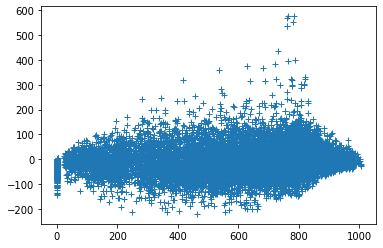

In [198]:
#residual plot
a = y_predict - y_valid
plt.plot(y_predict[0:35000],a[0:35000],'+')

#model predicts better at lower values

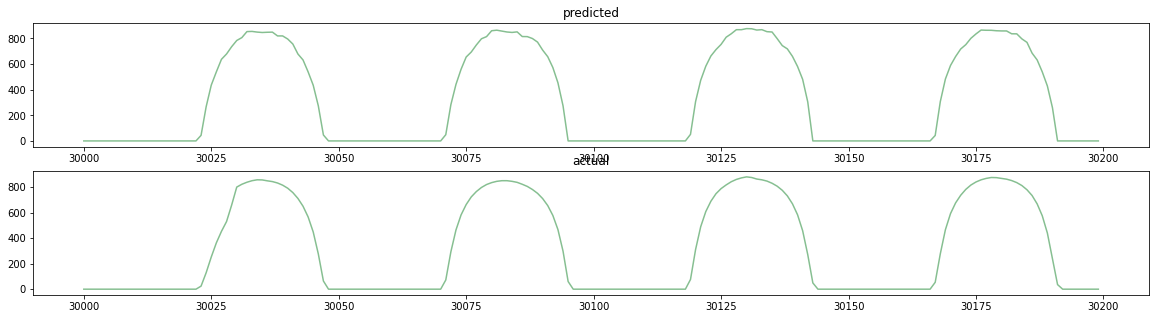

In [199]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
#plt.plot(X_valid_sc.index[0:200],y_predict[0:200], '+')

ax1 = plt.subplot(211)
plt.plot(X_valid_sc.index[30000:30200],y_predict[30000:30200],color='#86bf91')
ax1.title.set_text('predicted')

ax2 = plt.subplot(212, sharex = ax1)
plt.plot(X_valid_sc.index[30000:30200],y_valid[30000:30200],color='#86bf91')
ax2.title.set_text('actual')

In [65]:
# X will be the same, we need to change Y 
y = df['Clearsky GHI']
y_train = y[train_date[0]:train_date[1]]
y_valid = y[valid_date[0]:valid_date[1]]

print(y_train.shape)
print(y_valid.shape)

# we will be using the earlier scaled Xs

(140256,)
(35040,)


# Random forest performance for GHI
MSE : 90.13869693717295 </br>
R2 : 0.9991617530888537

after using day month year hour in the model </br>
MSE 49 </br>
R2 0.9995

In [66]:
# using the same template for GHI
forest_mod = RandomForestRegressor()
parameters = {
#    'n_estimators': [20,70,150],
    'n_estimators': [150],    
#    'min_samples_leaf': [10,20,50]
    'min_samples_leaf': [10]    
#    'kernel':['poly', 'rbf', 'sigmoid'],
#    'degree' : [1,2,3,4]
    
}
model = GridSearchCV(estimator =forest_mod,param_grid = parameters, cv = 3, scoring = 'neg_mean_squared_error' )
model_cv_GHI=model.fit(X_train_sc,y_train)
y_predict = model_cv_GHI.predict(X_valid_sc)

print(mean_squared_error(y_valid,y_predict))
print(r2_score(y_valid,y_predict))
print(model_cv_GHI.best_params_)

# best params - {'min_samples_leaf': 10, 'n_estimators': 150}

49.192265679490895
0.9995425353798174
{'min_samples_leaf': 10, 'n_estimators': 150}


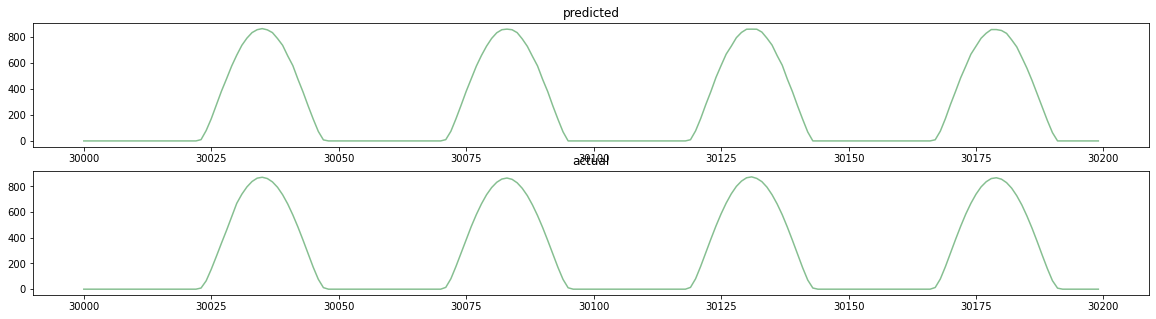

In [67]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
#plt.plot(X_valid_sc.index[0:200],y_predict[0:200], '+')

ax1 = plt.subplot(211)
plt.plot(X_valid_sc.index[30000:30200],y_predict[30000:30200],color='#86bf91')
ax1.title.set_text('predicted')

ax2 = plt.subplot(212, sharex = ax1)
plt.plot(X_valid_sc.index[30000:30200],y_valid[30000:30200],color='#86bf91')
ax2.title.set_text('actual')

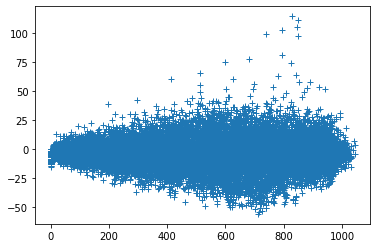

In [80]:
#residual plot
a = y_predict - y_valid
plt.plot(y_predict[0:35000],a[0:35000],'+')

#model predicts better at lower values

# predicting on test X dataset

In [68]:
dft = pd.read_csv('test.csv')

In [69]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                17520 non-null  int64  
 1   Month               17520 non-null  int64  
 2   Day                 17520 non-null  int64  
 3   Hour                17520 non-null  int64  
 4   Minute              17520 non-null  int64  
 5   Cloud Type          17520 non-null  int64  
 6   Dew Point           17520 non-null  float64
 7   Temperature         17520 non-null  float64
 8   Pressure            17520 non-null  int64  
 9   Relative Humidity   17520 non-null  float64
 10  Solar Zenith Angle  17520 non-null  float64
 11  Precipitable Water  17520 non-null  float64
 12  Wind Direction      17520 non-null  int64  
 13  Wind Speed          17520 non-null  float64
 14  Fill Flag           17520 non-null  int64  
 15  Clearsky DHI        0 non-null      float64
 16  Clea

In [70]:
dft['Date'] = dft['Year'].astype(str) +'-'+ dft['Month'].astype(str)+'-'+ dft['Day'].astype(str) +' '+ dft['Hour'].astype(str) +':'+ dft['Minute'].astype(str)+':00' 
dft['Date'] = pd.to_datetime(dft['Date'])

In [71]:
#one hot encoding Cloud types

dft['Cloud Type mod'] = dft['Cloud Type'].map(Cloud_Type_dict)

Cloud_Type_dummies = pd.get_dummies(dft['Cloud Type mod'], prefix='Cloud_Type', prefix_sep='_')
dft = pd.concat([dft,Cloud_Type_dummies], axis=1)
dft = dft.drop(['Cloud Type','Cloud Type mod'], axis =1)

In [72]:
dft.shape

(17520, 26)

In [73]:
dft['Fill Flag'].value_counts()

0      15670
100      375
14       196
29       150
4        147
43       141
7        110
57       107
71        98
86        71
11        69
18        50
21        48
36        28
39        27
25        25
32        23
50        20
68        19
93        18
46        18
75        17
82        16
64        16
79        15
54        14
89        13
61        11
96         8
Name: Fill Flag, dtype: int64

In [74]:
dft['Fill Flag mod'] = dft['Fill Flag'].map(Fill_Flag_dict)
Fill_Flag_dummies = pd.get_dummies(dft['Fill Flag mod'], prefix='Fill_Flag', prefix_sep='_')
dft = pd.concat([dft,Fill_Flag_dummies], axis=1)
dft = dft.drop(['Fill Flag','Fill Flag mod'], axis =1)
#no fill flag mapping present in test

In [75]:
dft.shape

(17520, 25)

In [76]:
dft = dft.set_index(dft['Date'], drop = True)
#dft = dft.drop(['Year','Month','Day','Hour','Minute','Date'], axis =1)
dft = dft.drop(['Minute','Date'], axis =1)

In [77]:
X_test = dft.drop(['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'], axis =1)

In [78]:
X_test.shape

(17520, 20)

In [79]:
print(X['Cloud_Type_Probably Clear'].value_counts())
print(X['Fill_Flag_Exceeds Clearsky'].value_counts()) 

0    159598
1     15698
Name: Cloud_Type_Probably Clear, dtype: int64
0    175006
1       290
Name: Fill_Flag_Exceeds Clearsky, dtype: int64


In [80]:
X.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Dew Point', 'Temperature', 'Pressure',
       'Relative Humidity', 'Solar Zenith Angle', 'Precipitable Water',
       'Wind Direction', 'Wind Speed', 'Cloud_Type_Cirrus', 'Cloud_Type_Clear',
       'Cloud_Type_Fog', 'Cloud_Type_Opaque Ice', 'Cloud_Type_Overlapping',
       'Cloud_Type_Overshooting', 'Cloud_Type_Probably Clear',
       'Cloud_Type_Super-Cooled Water', 'Cloud_Type_Water',
       'Fill_Flag_Exceeds Clearsky'],
      dtype='object')

In [81]:
X_test.columns
# Cloud_Type_Probably Clear and Fill_Flag_Exceeds Clearsky are missing in test

Index(['Year', 'Month', 'Day', 'Hour', 'Dew Point', 'Temperature', 'Pressure',
       'Relative Humidity', 'Solar Zenith Angle', 'Precipitable Water',
       'Wind Direction', 'Wind Speed', 'Cloud_Type_Cirrus', 'Cloud_Type_Clear',
       'Cloud_Type_Fog', 'Cloud_Type_Opaque Ice', 'Cloud_Type_Overlapping',
       'Cloud_Type_Overshooting', 'Cloud_Type_Super-Cooled Water',
       'Cloud_Type_Water'],
      dtype='object')

In [82]:
# 2 columns less in test due to some dummy mapped variable not present in test dataset. 
#therefore, we will create those cols with Zeros as hardcoded values
X_test['Cloud_Type_Probably Clear'] = 0
X_test['Fill_Flag_Exceeds Clearsky'] = 0


In [83]:
# Rearraging columns since scaling words in the same order as it was fit before
cols = X_test.columns.tolist()
cols = ['Year', 'Month', 'Day', 'Hour', 'Dew Point', 'Temperature', 'Pressure',
       'Relative Humidity', 'Solar Zenith Angle', 'Precipitable Water',
       'Wind Direction', 'Wind Speed', 'Cloud_Type_Cirrus', 'Cloud_Type_Clear',
       'Cloud_Type_Fog', 'Cloud_Type_Opaque Ice', 'Cloud_Type_Overlapping',
       'Cloud_Type_Overshooting', 'Cloud_Type_Probably Clear',
       'Cloud_Type_Super-Cooled Water', 'Cloud_Type_Water',
       'Fill_Flag_Exceeds Clearsky']
X_test = X_test[cols]

In [84]:
X_test.shape

(17520, 22)

In [85]:
X_test_sc = scaler.transform(X_test)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)

In [192]:
y_predict_DHI = model_cv_DHI.predict(X_test_sc)
y_predict_DNI = model_cv_DNI.predict(X_test_sc)
y_predict_GHI = model_cv_GHI.predict(X_test_sc)

In [166]:
X_test_sc.shape

(17520, 22)

In [167]:
#y_predict_DNI = y_predict_DNI**(1.3)

In [231]:
a = []
for i in range(0,len(y_predict_DNI)):
    
    if (y_predict_DNI[i]<10):
        a.append(0)
    else:
        a.append(y_predict_DNI[i])
y_predict_DNI = np.array(a)

In [232]:
y_predict_DNI

array([  0.        ,   0.        ,   0.        , ..., 175.74754333,
         0.        ,   0.        ])

In [234]:
final_submission = pd.DataFrame(list(zip(y_predict_DHI,y_predict_DNI,y_predict_GHI)),columns =['Clearsky DHI','Clearsky DNI','Clearsky GHI'])

In [235]:
final_submission.to_csv('my_submission_file.csv', index=False)

In [191]:
# storing models and loading
"""
filename = 'model_cv_DHI.sav'
pickle.dump(model_cv_DHI, open(filename, 'wb'))

filename = 'model_cv_DNI.sav'
pickle.dump(model_cv_DNI, open(filename, 'wb'))

filename = 'model_cv_GHI.sav'
pickle.dump(model_cv_GHI, open(filename, 'wb'))
"""
# some time later...
"""
# load the model from disk
model_cv_DHI = pickle.load(open('model_cv_DHI.sav', 'rb'))
model_cv_GHI = pickle.load(open('model_cv_GHI.sav', 'rb'))
"""